In [49]:
import pandas as pd
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import gzip
import json
import numpy as np

data = "810"
max_assembly = 5
min_samples = 21

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

In [7]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/*.pkl")]

### Read in the data

In [8]:
with open(f'/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/binary/binary_{min_samples}.pkl', 'rb') as f:
	d = pickle.load(f)

/home/gomez/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:27:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [9]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			first_gene = s.sort_values(ascending=False).index[0]
			first_value = s.sort_values(ascending=False)[0]
			ner = d[rel][i][0][0]
			if len(s) >= 2:
				second_value = s.sort_values(ascending=False)[1]
				second_gene = s.sort_values(ascending=False).index[1]
			else:
				second_value = 0
				second_gene = ""
			if len(s) >= 3:
				third_value = s.sort_values(ascending=False)[2]
				third_gene = s.sort_values(ascending=False).index[2]
			else:
				third_value = 0
				third_gene = ""
			if len(s) >= 4:
				last_value = s.sort_values(ascending=False)[-1]
				last_gene = s.sort_values(ascending=False).index[-1]
			else:
				last_value = 0
				last_gene = ""
			l.append([rel, ner, first_value, first_gene, second_value, second_gene, third_value, third_gene, last_value, last_gene])


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_56101/2750966354.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_value = s.sort_values(ascending=False)[0]
/tmp/ipykernel_56101/2750966354.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  second_value = s.sort_values(ascending=False)[1]
/tmp/ipykernel_56101/2750966354.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  third_value = s.sort_values(ascending=False)[2]
/tmp/ipykernel_56101/2750966354.py:22

In [10]:
df = pd.DataFrame(l,columns=["rel","ner","first_value","first_gene","second_value","second_gene","third_value","third_gene","last_value","last_gene"])

In [11]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-ORGANISM:INFECTS,mouse,10.132375,Polysaccharide biosynthesis protein,9.143670,Protein of unknown function DUF1706,5.005792,"Large ribosomal subunit protein uL22, conserve...",0.116391,"Protein of unknown function DUF2254, membrane"
1,STRAIN-COMPOUND:RESISTS,copper,10.639959,Amicyanin,8.185978,PAC motif,6.721899,"Upf1-like, C-terminal helicase domain",0.008444,"ABC transporter-like, ATP-binding domain"
2,STRAIN-COMPOUND:RESISTS,heavy metal,11.563549,"TonB-dependent receptor-like, beta-barrel",11.375634,Protein of unknown function DUF72,10.671868,TonB-dependent receptor-like,0.004440,"Glucose-1-phosphate thymidylyltransferase, sho..."
3,STRAIN-METABOLITE:RESISTS,streptomycin,11.550235,RNA-directed DNA polymerase (reverse transcrip...,9.949520,"Copper resistance protein ScsC, N-terminal",8.457993,"Lipase, secreted",0.027973,Protein of unknown function DUF465
4,STRAIN-METABOLITE:RESISTS,kanamycin,8.995494,Polyketide cyclase SnoaL-like,7.271872,"Extradiol ring-cleavage dioxygenase, class III...",6.460336,ArgJ-like domain superfamily,0.003019,Thiamine phosphate synthase
...,...,...,...,...,...,...,...,...,...,...
161,STRAIN-METABOLITE:PRODUCES,acetone,10.630218,"Phosphotransferase system, lactose/cellobiose-...",8.559192,Uronate isomerase,6.228765,"Reverse rubrerythrin, di-iron-binding domain",0.001295,"Transcription regulator, HTH DeoR-type, conser..."
162,STRAIN-METABOLITE:PRODUCES,phosphatidylglycerol,3.088914,"Pseudouridine synthase I, TruA, alpha/beta domain",2.796371,UDP-glucose/GDP-mannose dehydrogenase,2.780207,Trimethylamine methyltransferase,0.000565,"Nitrous oxide reductase, N-terminal"
163,STRAIN-METABOLITE:PRODUCES,glycogen,4.909141,CRISPR-associated protein Crn3/Csx3,3.682761,TGS,3.675270,"Transcription regulator HTH, GntR",0.000016,"Carbohydrate kinase, FGGY, conserved site"
164,STRAIN-METABOLITE:PRODUCES,phosphatidylethanolamine,6.287704,"Isoniazid-inducible protein IniB-like, N-termi...",6.137018,"2,4-diaminopentanoate dehydrogenase, C-termina...",6.124329,SGNH domain,0.000177,Pyridoxal phosphate-dependent decarboxylase


In [12]:
cutoff = df[df["first_value"] > 0.15].sort_values("first_value")

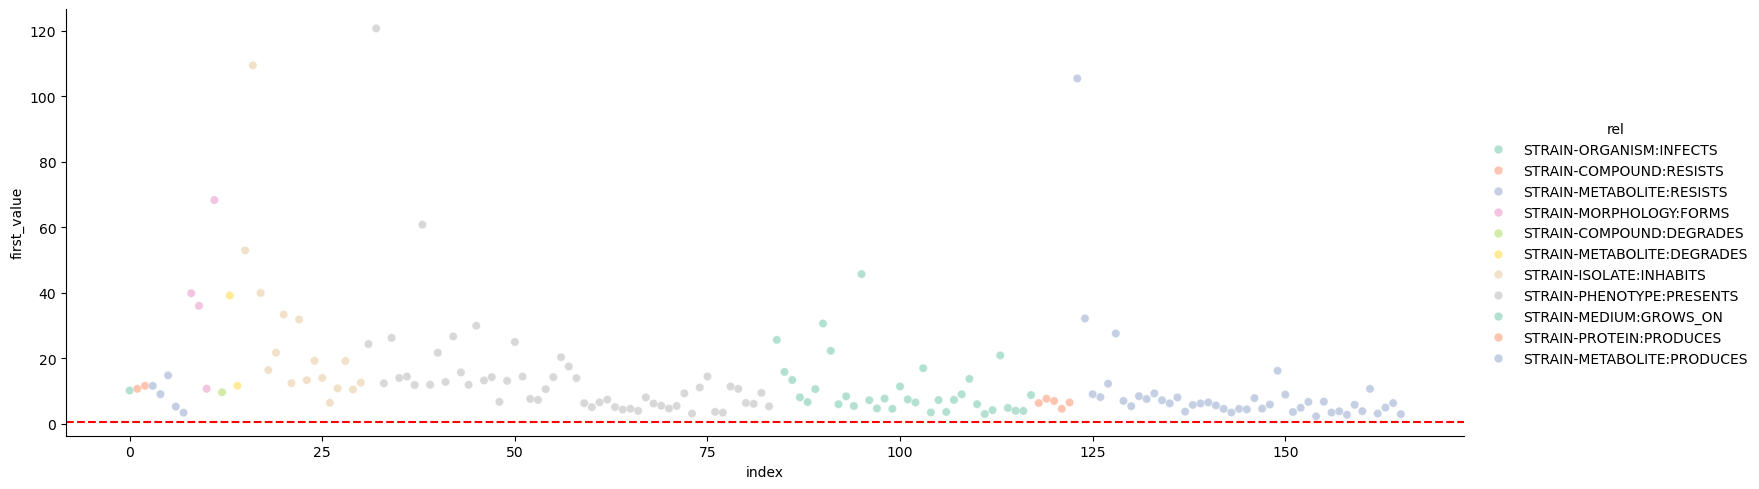

In [13]:
sns.relplot(y="first_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

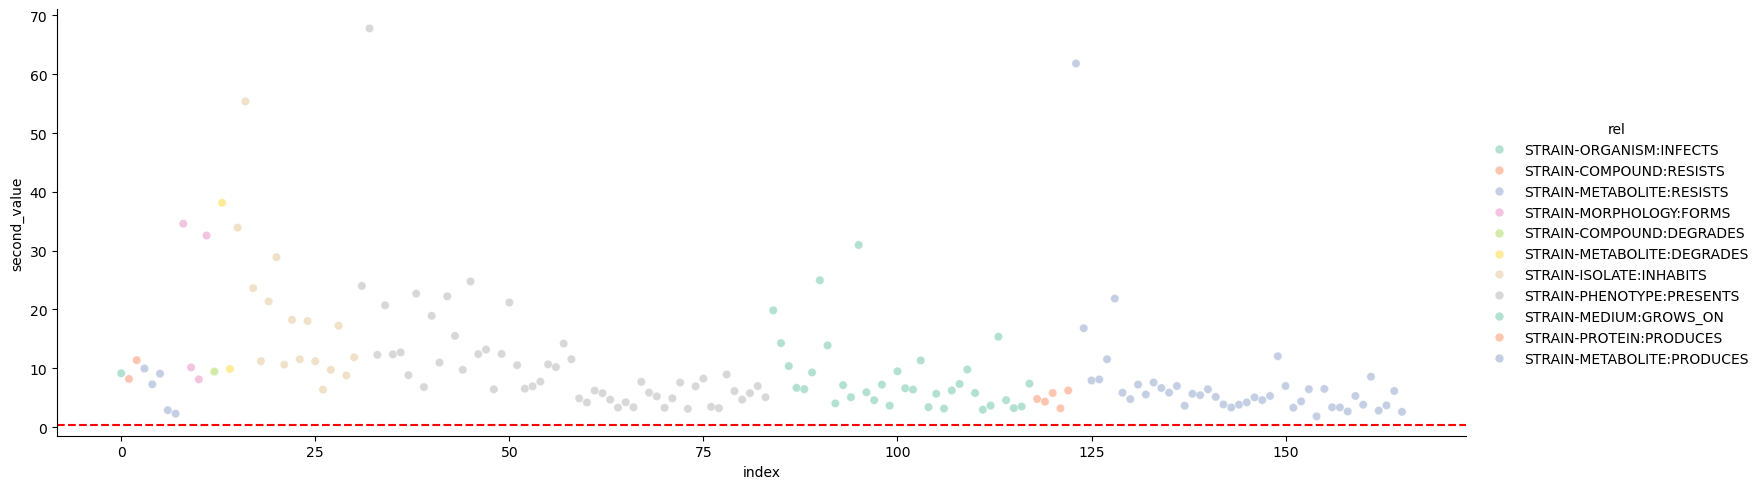

In [14]:
sns.relplot(y="second_value", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

<Axes: ylabel='Frequency'>

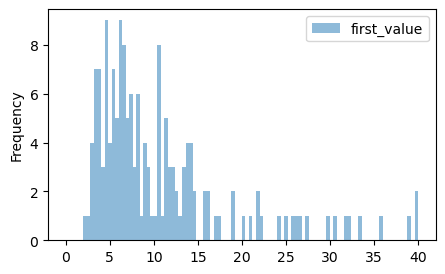

In [15]:
df.plot(kind='hist',y="first_value",bins=100,range=(0,40),alpha=0.5)

#### Group by function

In [16]:
df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
0,STRAIN-ORGANISM:INFECTS,mouse,10.132375,Polysaccharide biosynthesis protein,9.143670,Protein of unknown function DUF1706,5.005792,"Large ribosomal subunit protein uL22, conserve...",0.116391,"Protein of unknown function DUF2254, membrane"
1,STRAIN-COMPOUND:RESISTS,copper,10.639959,Amicyanin,8.185978,PAC motif,6.721899,"Upf1-like, C-terminal helicase domain",0.008444,"ABC transporter-like, ATP-binding domain"
2,STRAIN-COMPOUND:RESISTS,heavy metal,11.563549,"TonB-dependent receptor-like, beta-barrel",11.375634,Protein of unknown function DUF72,10.671868,TonB-dependent receptor-like,0.004440,"Glucose-1-phosphate thymidylyltransferase, sho..."
3,STRAIN-METABOLITE:RESISTS,streptomycin,11.550235,RNA-directed DNA polymerase (reverse transcrip...,9.949520,"Copper resistance protein ScsC, N-terminal",8.457993,"Lipase, secreted",0.027973,Protein of unknown function DUF465
4,STRAIN-METABOLITE:RESISTS,kanamycin,8.995494,Polyketide cyclase SnoaL-like,7.271872,"Extradiol ring-cleavage dioxygenase, class III...",6.460336,ArgJ-like domain superfamily,0.003019,Thiamine phosphate synthase
...,...,...,...,...,...,...,...,...,...,...
161,STRAIN-METABOLITE:PRODUCES,acetone,10.630218,"Phosphotransferase system, lactose/cellobiose-...",8.559192,Uronate isomerase,6.228765,"Reverse rubrerythrin, di-iron-binding domain",0.001295,"Transcription regulator, HTH DeoR-type, conser..."
162,STRAIN-METABOLITE:PRODUCES,phosphatidylglycerol,3.088914,"Pseudouridine synthase I, TruA, alpha/beta domain",2.796371,UDP-glucose/GDP-mannose dehydrogenase,2.780207,Trimethylamine methyltransferase,0.000565,"Nitrous oxide reductase, N-terminal"
163,STRAIN-METABOLITE:PRODUCES,glycogen,4.909141,CRISPR-associated protein Crn3/Csx3,3.682761,TGS,3.675270,"Transcription regulator HTH, GntR",0.000016,"Carbohydrate kinase, FGGY, conserved site"
164,STRAIN-METABOLITE:PRODUCES,phosphatidylethanolamine,6.287704,"Isoniazid-inducible protein IniB-like, N-termi...",6.137018,"2,4-diaminopentanoate dehydrogenase, C-termina...",6.124329,SGNH domain,0.000177,Pyridoxal phosphate-dependent decarboxylase


In [17]:
df.value_counts("first_gene")

first_gene
EF-hand domain pair                            2
LPXTG cell wall anchor domain                  2
4-oxalocrotonate tautomerase                   1
Protein of unknown function DUF5024            1
Porin, LamB-type                               1
                                              ..
Glycoside hydrolase family 9                   1
Glycoside hydrolase, family 25                 1
Glycoside hydrolase, family 4                  1
Glycosyltransferase family 23 (GT23) domain    1
_NiFe_-hydrogenase, large subunit              1
Name: count, Length: 164, dtype: int64

In [18]:
df[df["first_gene"]=="Cytochrome b5-like heme/steroid binding domain"]

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene
106,STRAIN-MEDIUM:GROWS_ON,trypticase soy broth,3.580994,Cytochrome b5-like heme/steroid binding domain,3.148228,PT repeat,3.065368,"dTDP-glucose 4,6-dehydratase",0.001333,YefM-like superfamily


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [19]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
assemblies = pd.concat(assemblies_perner)

In [21]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [22]:
merged_df

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count
0,STRAIN-ORGANISM:INFECTS,mouse,10.132375,Polysaccharide biosynthesis protein,9.143670,Protein of unknown function DUF1706,5.005792,"Large ribosomal subunit protein uL22, conserve...",0.116391,"Protein of unknown function DUF2254, membrane",29
1,STRAIN-COMPOUND:RESISTS,copper,10.639959,Amicyanin,8.185978,PAC motif,6.721899,"Upf1-like, C-terminal helicase domain",0.008444,"ABC transporter-like, ATP-binding domain",30
2,STRAIN-COMPOUND:RESISTS,heavy metal,11.563549,"TonB-dependent receptor-like, beta-barrel",11.375634,Protein of unknown function DUF72,10.671868,TonB-dependent receptor-like,0.004440,"Glucose-1-phosphate thymidylyltransferase, sho...",21
3,STRAIN-METABOLITE:RESISTS,streptomycin,11.550235,RNA-directed DNA polymerase (reverse transcrip...,9.949520,"Copper resistance protein ScsC, N-terminal",8.457993,"Lipase, secreted",0.027973,Protein of unknown function DUF465,32
4,STRAIN-METABOLITE:RESISTS,kanamycin,8.995494,Polyketide cyclase SnoaL-like,7.271872,"Extradiol ring-cleavage dioxygenase, class III...",6.460336,ArgJ-like domain superfamily,0.003019,Thiamine phosphate synthase,28
...,...,...,...,...,...,...,...,...,...,...,...
161,STRAIN-METABOLITE:PRODUCES,acetone,10.630218,"Phosphotransferase system, lactose/cellobiose-...",8.559192,Uronate isomerase,6.228765,"Reverse rubrerythrin, di-iron-binding domain",0.001295,"Transcription regulator, HTH DeoR-type, conser...",21
162,STRAIN-METABOLITE:PRODUCES,phosphatidylglycerol,3.088914,"Pseudouridine synthase I, TruA, alpha/beta domain",2.796371,UDP-glucose/GDP-mannose dehydrogenase,2.780207,Trimethylamine methyltransferase,0.000565,"Nitrous oxide reductase, N-terminal",21
163,STRAIN-METABOLITE:PRODUCES,glycogen,4.909141,CRISPR-associated protein Crn3/Csx3,3.682761,TGS,3.675270,"Transcription regulator HTH, GntR",0.000016,"Carbohydrate kinase, FGGY, conserved site",21
164,STRAIN-METABOLITE:PRODUCES,phosphatidylethanolamine,6.287704,"Isoniazid-inducible protein IniB-like, N-termi...",6.137018,"2,4-diaminopentanoate dehydrogenase, C-termina...",6.124329,SGNH domain,0.000177,Pyridoxal phosphate-dependent decarboxylase,21


In [23]:
merged_df.sort_values("count")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count
82,STRAIN-PHENOTYPE:PRESENTS,photoautotrophic,9.425134,Domain of unknown function DUF6444,6.964035,"Orange carotenoid-binding protein, N-terminal ...",6.812561,"SLC12A transporter, C-terminal",0.000164,"Carbohydrate kinase, FGGY",21
163,STRAIN-METABOLITE:PRODUCES,glycogen,4.909141,CRISPR-associated protein Crn3/Csx3,3.682761,TGS,3.675270,"Transcription regulator HTH, GntR",0.000016,"Carbohydrate kinase, FGGY, conserved site",21
162,STRAIN-METABOLITE:PRODUCES,phosphatidylglycerol,3.088914,"Pseudouridine synthase I, TruA, alpha/beta domain",2.796371,UDP-glucose/GDP-mannose dehydrogenase,2.780207,Trimethylamine methyltransferase,0.000565,"Nitrous oxide reductase, N-terminal",21
161,STRAIN-METABOLITE:PRODUCES,acetone,10.630218,"Phosphotransferase system, lactose/cellobiose-...",8.559192,Uronate isomerase,6.228765,"Reverse rubrerythrin, di-iron-binding domain",0.001295,"Transcription regulator, HTH DeoR-type, conser...",21
160,STRAIN-METABOLITE:PRODUCES,ahls,3.817877,Sulfopropanediol 3-dehydrogenase,3.800078,Transcriptional regulator RsaM-like,3.747668,"Addiction module killer protein, predicted",0.004350,GPI inositol-deacylase PGAP1-like,21
...,...,...,...,...,...,...,...,...,...,...,...
123,STRAIN-METABOLITE:PRODUCES,c,105.438171,Pr6Pr membrane protein-like,61.823261,"Aspartate-tRNA ligase, type 1, anticodon recog...",51.560860,"Orc1-like, AAA ATPase domain",0.002101,"Phosphoenolpyruvate carboxykinase, ATP-utilising",230
15,STRAIN-ISOLATE:INHABITS,soil,52.905560,Condensation domain,33.917496,Non-ribosomal peptide synthase,24.342966,ACP-like superfamily,0.021487,Restriction system protein Mrr-like N-terminal...,234
8,STRAIN-MORPHOLOGY:FORMS,biofilm,39.841034,Helicase SWF/SNF-related,34.578350,Inositol monophosphatase-like,21.493536,"Large ribosomal subunit protein eL14, KOW motif",0.001648,Phosphofructokinase domain,386
32,STRAIN-PHENOTYPE:PRESENTS,gram - positive,120.727089,Sporulation regulator WhiA,67.790810,Permease LptG/LptF-related,38.348106,Bacterial surface antigen (D15),0.004369,Type IV secretion system protein TraG/VirD4,421


/tmp/ipykernel_56101/1829732332.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


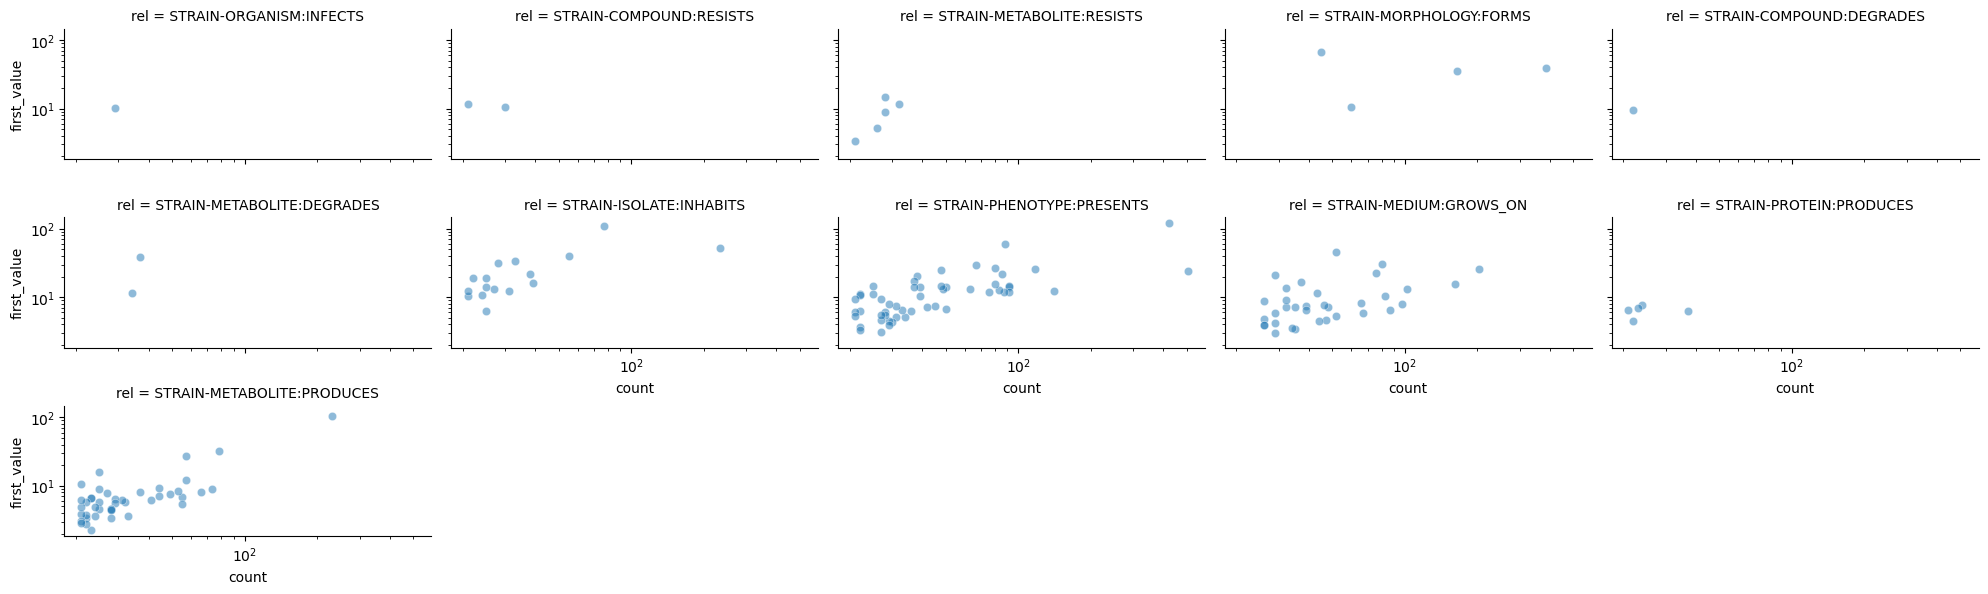

In [24]:
sns.relplot(y="first_value", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [25]:
merged_df['normalized_value'] = (merged_df['first_value'] * merged_df['count'])/100

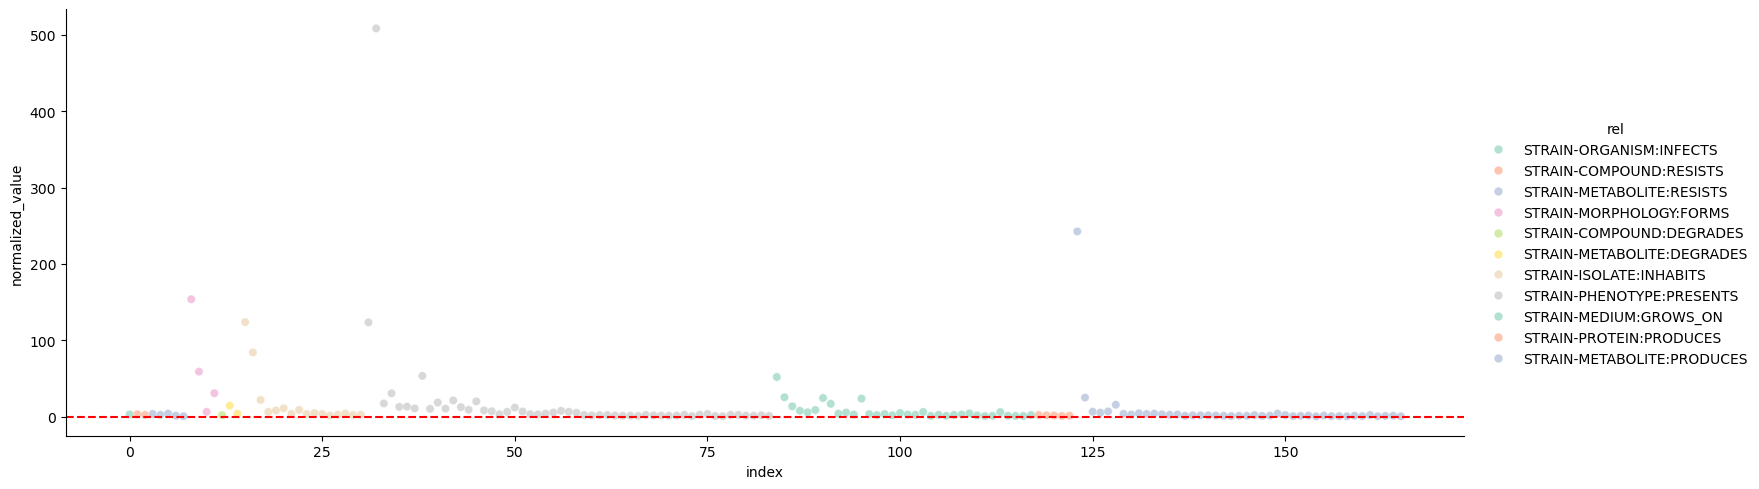

In [26]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [27]:
merged_df.sort_values("normalized_value")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value
154,STRAIN-METABOLITE:PRODUCES,fatty,2.239572,Glutamate synthase domain,1.825608,Amidohydrolase 3,1.779246,BCCT transporter family,0.000559,Structural maintenance of chromosomes protein,23,0.515102
158,STRAIN-METABOLITE:PRODUCES,pyruvate,2.720375,Glyoxalase/fosfomycin resistance/dioxygenase d...,2.649510,"Biotin carboxylase, C-terminal",2.567165,EF-hand domain,0.000645,CofD-like domain superfamily,22,0.598483
165,STRAIN-METABOLITE:PRODUCES,formate,2.900009,Ammonia monooxygenase/particulate methane mono...,2.587199,Formylmethanofuran: tetrahydromethanopterin fo...,1.790612,"Gamma-butyrobetaine hydroxylase-like, N-terminal",0.000067,"Translation initiation factor 3 (IF-3), C-term...",21,0.609002
162,STRAIN-METABOLITE:PRODUCES,phosphatidylglycerol,3.088914,"Pseudouridine synthase I, TruA, alpha/beta domain",2.796371,UDP-glucose/GDP-mannose dehydrogenase,2.780207,Trimethylamine methyltransferase,0.000565,"Nitrous oxide reductase, N-terminal",21,0.648672
7,STRAIN-METABOLITE:RESISTS,ampicillin,3.350684,GHMP kinase N-terminal domain,2.283385,ESPR domain,2.026261,S-adenosyl-L-methionine-dependent methyltransf...,0.000299,Histidine kinase/HSP90-like ATPase,21,0.703644
...,...,...,...,...,...,...,...,...,...,...,...,...
31,STRAIN-PHENOTYPE:PRESENTS,gram - negative,24.312550,"Fe(2+)-dicitrate sensor, transmembrane component",23.994677,"Ferredoxin--NADP reductase, bacteria",23.657700,Protein of unknown function DUF1287,0.019615,Putative methionine gamma-lyase,508,123.507752
15,STRAIN-ISOLATE:INHABITS,soil,52.905560,Condensation domain,33.917496,Non-ribosomal peptide synthase,24.342966,ACP-like superfamily,0.021487,Restriction system protein Mrr-like N-terminal...,234,123.799009
8,STRAIN-MORPHOLOGY:FORMS,biofilm,39.841034,Helicase SWF/SNF-related,34.578350,Inositol monophosphatase-like,21.493536,"Large ribosomal subunit protein eL14, KOW motif",0.001648,Phosphofructokinase domain,386,153.786391
123,STRAIN-METABOLITE:PRODUCES,c,105.438171,Pr6Pr membrane protein-like,61.823261,"Aspartate-tRNA ligase, type 1, anticodon recog...",51.560860,"Orc1-like, AAA ATPase domain",0.002101,"Phosphoenolpyruvate carboxykinase, ATP-utilising",230,242.507794


#### Find features where top three are very close

In [28]:
merged_df["first_second_difference"] = merged_df.first_value - merged_df.second_value
merged_df["first_third_difference"] = merged_df.first_value - merged_df.third_value

In [29]:
merged_df[merged_df["first_second_difference"] <0.01]

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference
26,STRAIN-ISOLATE:INHABITS,sediment,6.371773,"Divalent ion tolerance protein, CutA",6.367897,"Peptidase M15A, C-terminal",6.051727,Cutinase/acetylxylan esterase,0.001804,Phosphopantetheine attachment site,25,1.592943,0.003876,0.320045
73,STRAIN-PHENOTYPE:PRESENTS,halotolerant,3.098821,SEC-C motif,3.098615,"OLD protein-like, TOPRIM domain",3.062826,"Endopeptidase, NLPC/P60 domain",0.001275,"Primase, C-terminal 2",27,0.836682,0.000206,0.035996
111,STRAIN-MEDIUM:GROWS_ON,lysogeny broth (,2.947714,Membrane-bound lytic murein transglycosylase F,2.939695,Protein of unknown function DUF2642,2.866686,"Uncharacterised domain UPF0302, N-terminal",0.000123,"Transposase, IS30, conserved site",29,0.854837,0.008019,0.081028
126,STRAIN-METABOLITE:PRODUCES,eps,8.102142,Prokaryotic E2 family C,8.096405,Protein of unknown function DUF3335,7.049276,3-oxopimeloyl-_acyl-carrier-protein_ synthase,0.001427,MOFRL domain,66,5.347414,0.005737,1.052866


In [30]:
merged_df[merged_df["first_third_difference"] <0.01].sort_values("first_third_difference")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference


## Evolution

### Run for all rows in merged_df and save files into a folder each

In [30]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}_{min_samples}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	relevant_parq = parq[parq['word_qc'].isin(filtered_df['ner'])] 
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = relevant_parq[relevant_parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty: 
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['first_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files and fna_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Create test set

In [16]:
# outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
# os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','-').replace('_',"-")
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

NameError: name 'merged_df' is not defined

In [ ]:

# Set the directory where the files are located
directory = "/home/gomez/gomez/seqfiles_linkbert_810_5_21"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(directory)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)


0it [00:00, ?it/s]

[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 17 duplicated records removed
[INFO] 17 duplicated records removed
[INFO] 1 duplicated records removed
[INFO] 1 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 28 duplicated records removed
[INFO] 28 duplicated records removed
[INFO] 11 duplicated records removed
[INFO] 11 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 10 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 8 duplicated records removed
[INFO] 8 duplicate

### Check if evolution matches importances

In [72]:
jsons = glob("/home/gomez/gomez/seqfiles_linkbert_810_5_21/*/seq.json")


In [73]:
data = []
for json_file in tqdm(jsons, desc="Processing JSON files"):
    folder_name = os.path.basename(os.path.dirname(json_file))
    try:
        with open(json_file) as f:
            json_data = json.load(f)
            p_value = json_data["test results"]["p-value"]
            lrt = json_data["test results"]["LRT"]
            data.append({'name': folder_name, 'p_value': p_value, 'lrt': lrt})
    except json.JSONDecodeError:
        continue

evolution = pd.DataFrame(data)


Processing JSON files:   0%|          | 0/153 [00:00<?, ?it/s]

In [74]:
evolution["gene"] = evolution.name.str.split("_",expand=True,n=2)[0]
evolution["rel"] = evolution.name.str.split("_",expand=True,n=2)[1]
evolution["ner"] = evolution.name.str.split("_",expand=True,n=2)[2]

In [75]:
merged_df["rel"] = merged_df.rel.str.replace(':','-').str.replace('_',"-")
merged_df["ner"] = merged_df.ner.str.replace(' ','_').str.replace("'",'').str.replace('(','_').str.replace(')','_')

In [78]:
all_merged = merged_df.merge(evolution, on=["rel","ner"])

In [79]:
all_merged.sort_values("p_value")

,rel,ner,first_value,first_gene,second_value,second_gene,third_value,third_gene,last_value,last_gene,count,normalized_value,first_second_difference,first_third_difference,name,p_value,lrt,gene
102,STRAIN-MEDIUM-GROWS-ON,minimal,8.744724,TRAP transporter large membrane protein DctM,7.382580,"TRAP transporter solute receptor, DctP family",6.618213,17kDa common-antigen outer membrane protein,0.002859,Flavin oxidoreductase Frp family,26,2.273628,1.362144,2.126512,first_STRAIN-MEDIUM-GROWS-ON_minimal,0.0,79.566352,first
25,STRAIN-PHENOTYPE-PRESENTS,gram_-_positive,120.727089,Sporulation regulator WhiA,67.790810,Permease LptG/LptF-related,38.348106,Bacterial surface antigen (D15),0.004369,Type IV secretion system protein TraG/VirD4,421,508.261044,52.936279,82.378983,first_STRAIN-PHENOTYPE-PRESENTS_gram_-_positive,0.0,323.397083,first
36,STRAIN-PHENOTYPE-PRESENTS,endophytic,13.205086,MmyB-like transcription regulator ligand binding,12.407825,"Alpha-L-arabinofuranosidase B, catalytic",11.782349,"1, 4-beta cellobiohydrolase",0.009445,Transposase IS630-like,63,8.319204,0.797261,1.422737,first_STRAIN-PHENOTYPE-PRESENTS_endophytic,0.0,85.556676,first
44,STRAIN-PHENOTYPE-PRESENTS,strictly_anaerobic,10.551470,Large cysteine-rich periplasmic protein OmcB-l...,7.722411,"Tail sheath protein, subtilisin-like domain",7.222632,"Desulfoferrodoxin, N-terminal domain",0.003592,ATP binding protein MinD/FleN,39,4.115073,2.829059,3.328838,first_STRAIN-PHENOTYPE-PRESENTS_strictly_anaer...,0.0,3436.302907,first
46,STRAIN-PHENOTYPE-PRESENTS,cellulolytic,20.313345,Glycoside hydrolase family 9,10.194448,Polysaccharide lyase family 11,6.140522,Amidohydrolase-related,0.003285,Uncharacterised conserved protein UCP022704,38,7.719071,10.118896,14.172823,first_STRAIN-PHENOTYPE-PRESENTS_cellulolytic,0.0,559.297684,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,STRAIN-MEDIUM-GROWS-ON,lb_agar,7.661005,"Sodium/sulphate symporter, conserved site",7.209213,"Porin, LamB-type",6.506170,Iron permease FTR1/Fip1/EfeU,0.002531,"Phosphoenolpyruvate carboxykinase, N-terminal",46,3.524062,0.451792,1.154835,first_STRAIN-MEDIUM-GROWS-ON_lb_agar,0.5,0.000000,first
19,STRAIN-ISOLATE-INHABITS,soil_collected,19.199692,"Serine proteases, trypsin domain",18.028610,"RNA polymerase sigma factor, region 3/4-like",15.635570,HTTM,0.000157,MAM domain,25,4.799923,1.171082,3.564122,first_STRAIN-ISOLATE-INHABITS_soil_collected,0.5,-0.826260,first
75,STRAIN-MEDIUM-GROWS-ON,mrs,30.589951,"Putative ornithine decarboxylase, Lactobacillus",24.959738,"Peptidase C69, dipeptidase A-like",16.961813,Radical SAM,0.002483,"GHMP kinase, C-terminal domain superfamily",80,24.471960,5.630213,13.628138,first_STRAIN-MEDIUM-GROWS-ON_mrs,0.5,0.000000,first
89,STRAIN-MEDIUM-GROWS-ON,luria_bertani__,3.417889,Multi antimicrobial extrusion protein,3.391474,Tagatose/fructose phosphokinase,3.290722,Protein of unknown function DUF1302,0.000363,TonB-dependent receptor-like,35,1.196261,0.026415,0.127167,first_STRAIN-MEDIUM-GROWS-ON_luria_bertani__,0.5,0.000000,first


In [87]:
all_merged["-log10(p_value)"] = -1 * all_merged["p_value"].apply(np.log10)
all_merged["logLRT"] = all_merged["lrt"].apply(np.log10)
all_merged["log_imp"] = all_merged["first_value"].apply(np.log10)

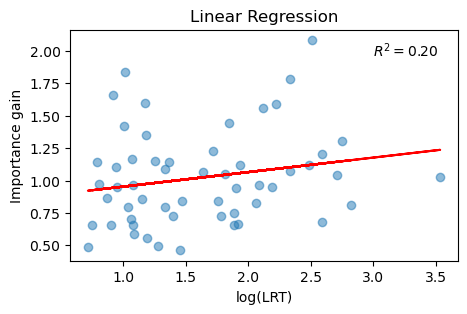

In [93]:
from scipy.stats import linregress
# Define the x and y values, filtering out np.nan values
x = all_merged[all_merged.p_value < 0.05]['logLRT'].dropna()
y = all_merged[all_merged.p_value < 0.05]['log_imp'].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the linear regression line
line = slope * x + intercept

# Plot the data points and linear regression line
plt.scatter(x, y, alpha=0.5)
plt.plot(x, line, color='red')

# Add the R^2 value as text on the side
plt.text(0.95, 0.95, f'$R^2 = ${r_value:.2f}', ha='right', va='top', transform=plt.gca().transAxes)

# Set the labels and title
plt.xlabel('log(LRT)')
plt.ylabel('Importance gain')
plt.title('Linear Regression')

# Show the plot
plt.show()


In [94]:
linregress(x, y)

LinregressResult(slope=0.11190912540763735, intercept=0.8408973042276237, rvalue=0.2018098196249611, pvalue=0.13953228014206132, stderr=0.07460300772627733, intercept_stderr=0.13026256428740546)

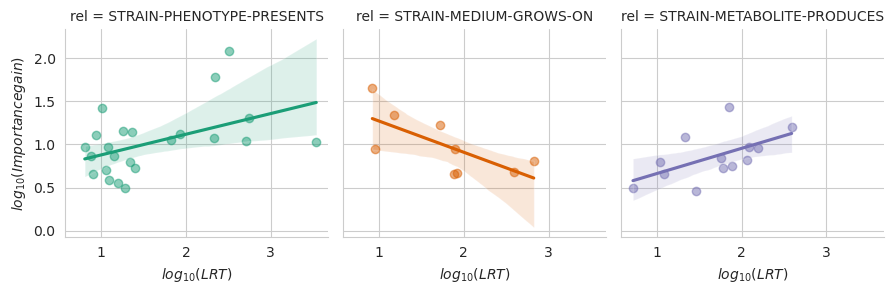

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette to the accent color set
sns.set_palette("Dark2")

# Your code for plotting the dataframe
g = sns.lmplot(x="logLRT", y="log_imp", col="rel", hue="rel", data=all_merged[(all_merged.p_value < 0.05) & (all_merged.rel.isin(["STRAIN-PHENOTYPE-PRESENTS", "STRAIN-METABOLITE-PRODUCES", "STRAIN-MEDIUM-GROWS-ON"]))], aspect=1, height=3, scatter_kws={"alpha": 0.5})
g.set_axis_labels("$log_{10}(LRT)$", "$log_{10}(Importance gain)$")
plt.savefig("figures/xgboost/positive_selection.pdf", bbox_inches="tight")
